In [ ]:
# Tickers para el análisis del mercado argentino
tickers = [
    # --- Acciones Líderes Argentinas (ADRs) ---
    'GGAL',   # Grupo Financiero Galicia
    'YPFD',   # YPF (la D es por la bolsa de NY, a veces es solo YPF)
    'PAMP',   # Pampa Energía
    'LOMA',   # Loma Negra (Cemento)
    'BMA',    # Banco Macro
    'MELI',   # MercadoLibre (aunque es Latam, es un gran jugador argentino)
    'IRS',    # IRSA (Inmuebles)
    'CRESY',  # Cresud (Agropecuario)

    # --- Índices de Referencia ---
    '^MERV',  # Índice S&P MERVAL (Buenos Aires)
    '^GSPC',  # S&P 500 (Para ver la conexión con EE.UU.)
    'EWZ',    # ETF de Brasil iShares (Principal socio comercial)

    # --- Commodities Clave ---
    'ZS=F',   # Soja (Soybean Futures)
    'ZC=F',   # Maíz (Corn Futures)
    'CL=F',   # Petróleo Crudo (Crude Oil Futures)
    'GC=F',   # Oro (Gold Futures, como activo de refugio)

    # --- Indicadores de Riesgo Global ---
    '^TNX'    # Tasa del Bono del Tesoro a 10 años de EE.UU. (refleja el costo del dinero global)
]

[************          25%                       ]  4 of 16 completed

Descargando datos de mercado...


[*********************100%***********************]  16 of 16 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['YPFD', 'PAMP']: YFTzMissingError('possibly delisted; no timezone found')


Datos descargados y limpios. Tickers utilizados finalmente:
['BMA', 'CL=F', 'CRESY', 'EWZ', 'GC=F', 'GGAL', 'IRS', 'LOMA', 'MELI', 'ZC=F', 'ZS=F', '^GSPC', '^MERV', '^TNX']

Generando gráfico de la red MST estática...


/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


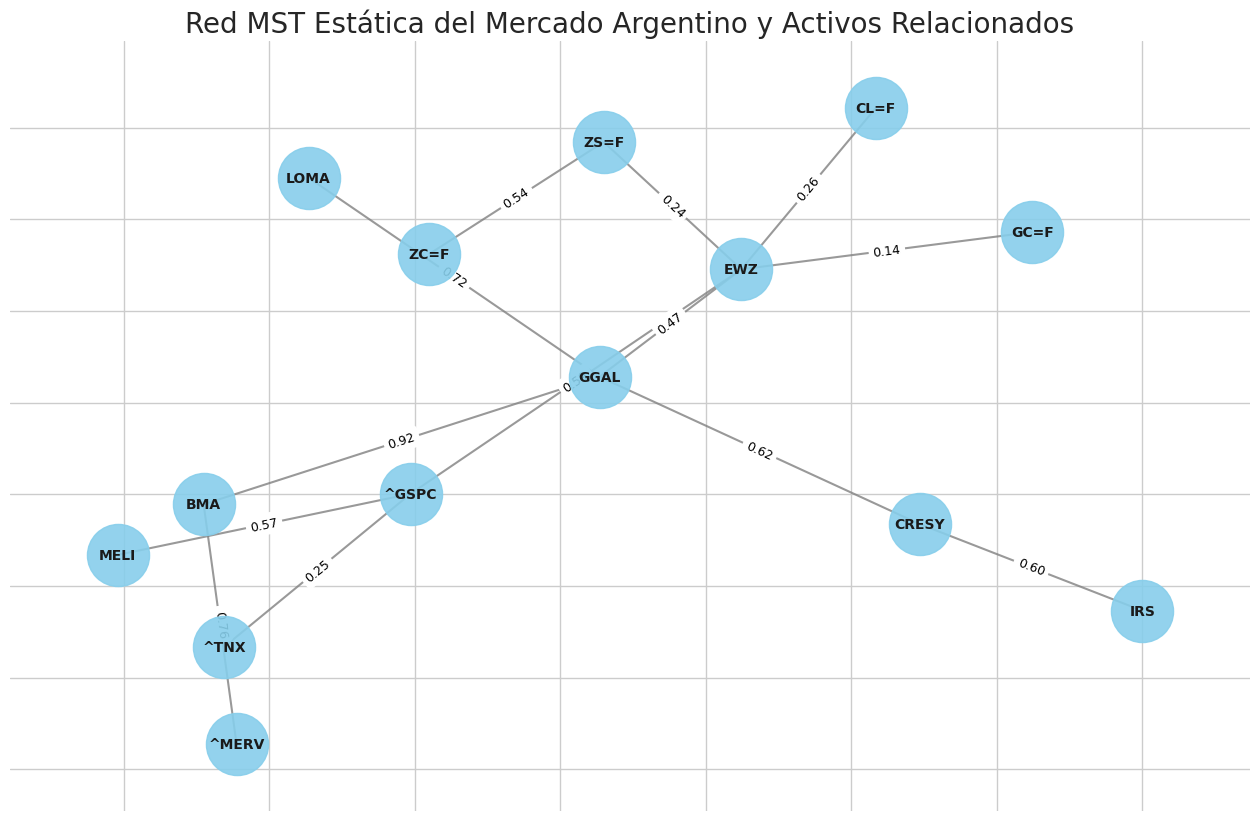


Extrayendo métricas de red con ventanas de 60 días...
Extracción de métricas completada.

Definiendo la variable objetivo 'crisis'...
Definición de crisis: Retorno del MERVAL a 60 días < -10.0%
Número de períodos de crisis identificados: 30

Entrenando el modelo RandomForest...

--- Resultados del Modelo ---
               precision    recall  f1-score   support

No Crisis (0)       0.92      0.85      0.88        84
   Crisis (1)       0.19      0.33      0.24         9

     accuracy                           0.80        93
    macro avg       0.55      0.59      0.56        93
 weighted avg       0.85      0.80      0.82        93


Generando gráfico de evolución de métricas...


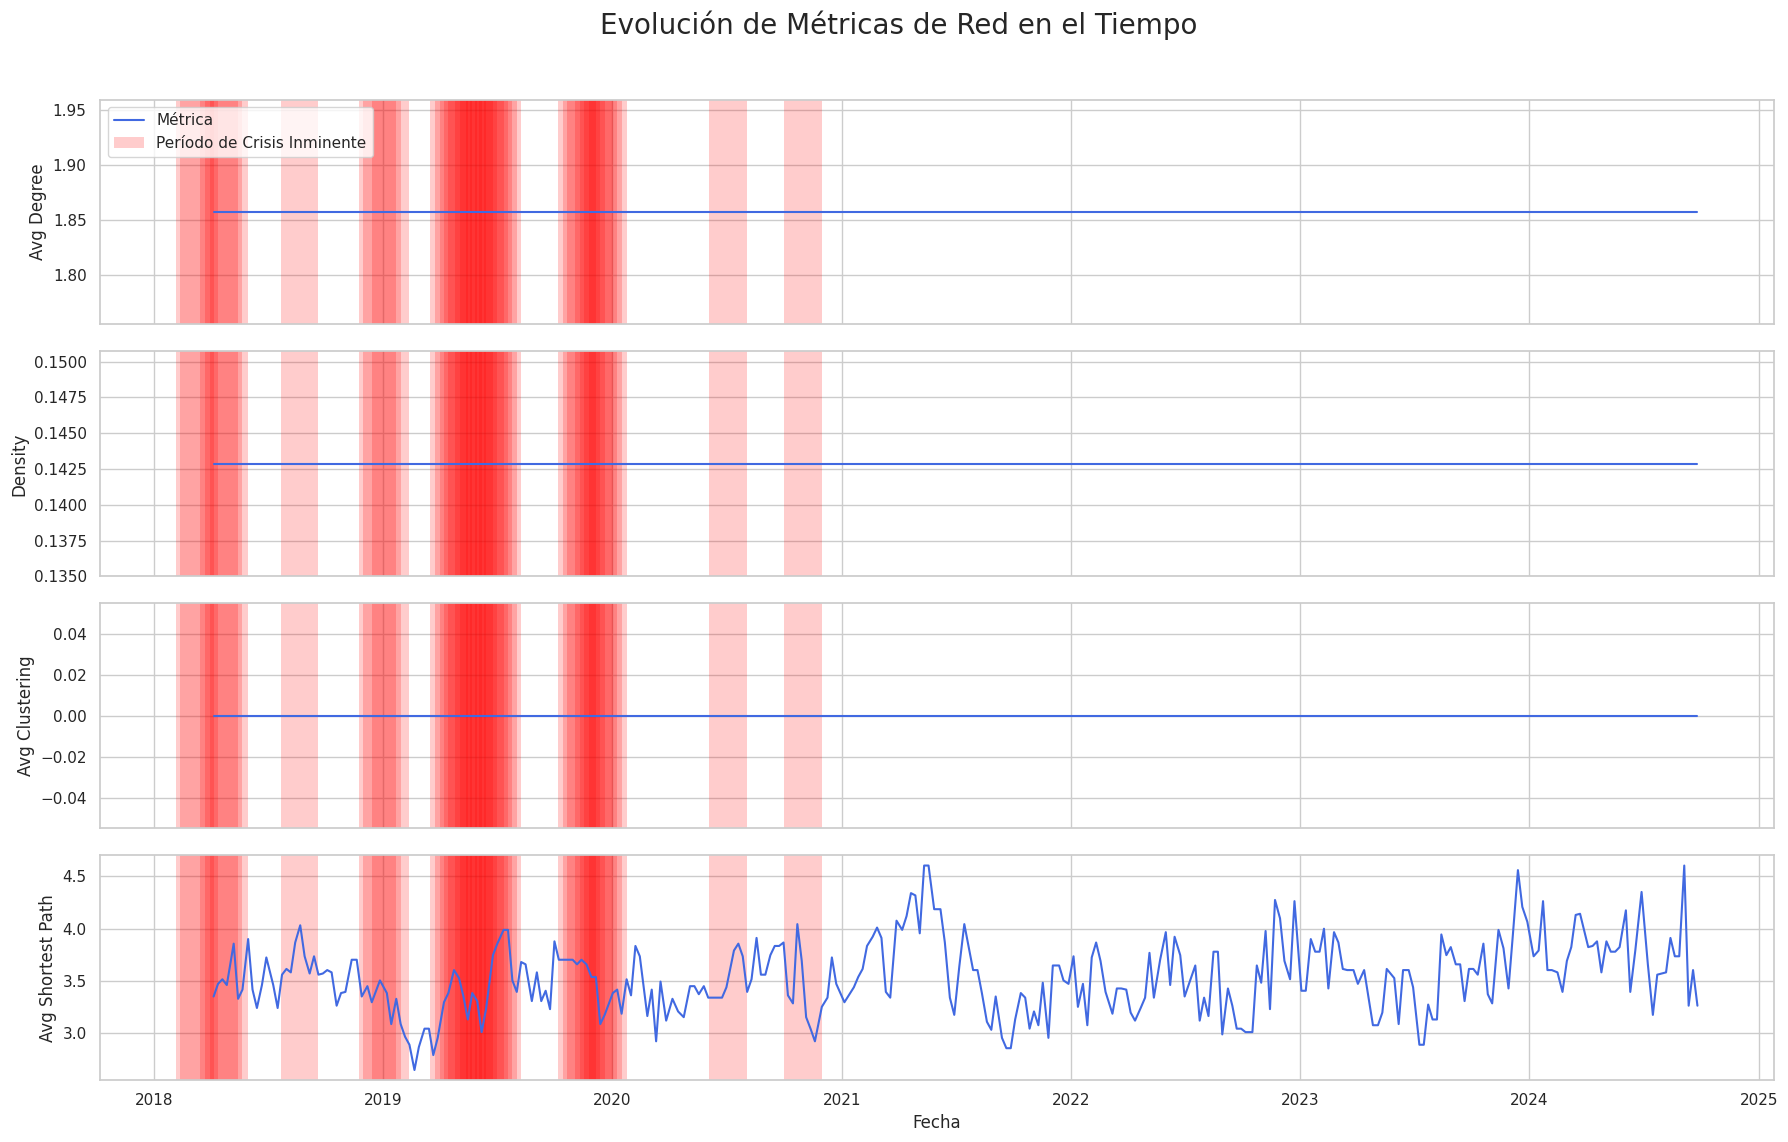


Generando gráfico de importancia de características...


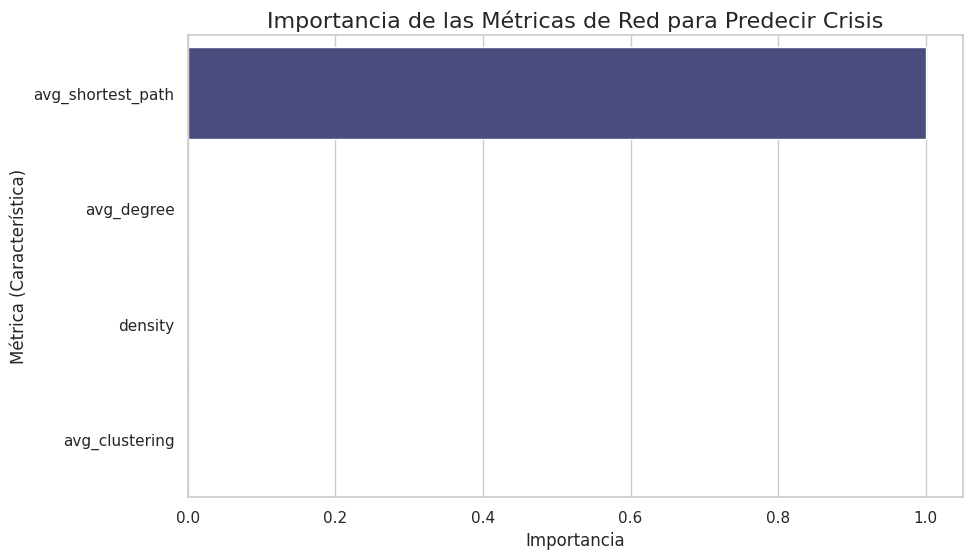

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# --- CONFIGURACIÓN INICIAL ---
# Ignorar advertencias comunes para una salida más limpia
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

# Configuración de estilo para los gráficos
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

# --- PASO 1: Definir el Universo de Activos para Argentina ---
tickers = [
    'GGAL', 'YPFD', 'PAMP', 'LOMA', 'BMA', 'MELI', 'IRS', 'CRESY',
    '^MERV', '^GSPC', 'EWZ',
    'ZS=F', 'ZC=F', 'CL=F', 'GC=F',
    '^TNX'
]

# --- PASO 2: Descargar y Preparar los Datos ---
print("Descargando datos de mercado...")
data = yf.download(tickers, start="2018-01-01", end="2025-01-01", auto_adjust=True)['Close']
data.dropna(axis=1, thresh=len(data) * 0.8, inplace=True)
data.dropna(axis=0, inplace=True)

print("Datos descargados y limpios. Tickers utilizados finalmente:")
print(data.columns.tolist())

log_returns = np.log(data / data.shift(1)).dropna()

# --- GRÁFICO 1: RED MST ESTÁTICA (Período Completo) ---
def plot_static_mst(log_returns_df):
    """
    Calcula y grafica el MST para todo el período de datos.
    """
    print("\nGenerando gráfico de la red MST estática...")
    corr_matrix = log_returns_df.corr()
    dist_matrix = np.sqrt(2 * (1 - corr_matrix))
    G = nx.from_pandas_adjacency(dist_matrix)
    mst = nx.minimum_spanning_tree(G)

    # Convertir distancias de vuelta a correlaciones para las etiquetas (más intuitivo)
    edge_labels = {}
    for u, v in mst.edges():
        corr = corr_matrix.loc[u, v]
        edge_labels[(u, v)] = f"{corr:.2f}"

    plt.figure(figsize=(16, 10))
    pos = nx.spring_layout(mst, k=0.75, iterations=50) # 'k' ajusta la distancia entre nodos

    nx.draw_networkx_nodes(mst, pos, node_size=2000, node_color='skyblue', alpha=0.9)
    nx.draw_networkx_edges(mst, pos, width=1.5, alpha=0.8, edge_color='gray')
    nx.draw_networkx_labels(mst, pos, font_size=10, font_weight='bold')
    nx.draw_networkx_edge_labels(mst, pos, edge_labels=edge_labels, font_size=9, font_color='black')

    plt.title('Red MST Estática del Mercado Argentino y Activos Relacionados', fontsize=20)
    plt.box(False)
    plt.show()

plot_static_mst(log_returns)


# --- PASO 3: Función para Extraer Métricas de Red ---
def extract_network_metrics(log_returns, window_size=60, step=5):
    metrics = []
    print(f"\nExtrayendo métricas de red con ventanas de {window_size} días...")
    for start in range(0, len(log_returns) - window_size, step):
        end = start + window_size
        window_data = log_returns.iloc[start:end]
        corr_matrix = window_data.corr()
        dist_matrix = np.sqrt(2 * (1 - corr_matrix))
        G = nx.from_pandas_adjacency(dist_matrix)
        mst = nx.minimum_spanning_tree(G)
        metrics.append({
            "end_date": log_returns.index[end - 1],
            "avg_degree": np.mean(list(dict(mst.degree()).values())),
            "density": nx.density(mst),
            "avg_clustering": nx.average_clustering(mst),
            "avg_shortest_path": nx.average_shortest_path_length(mst)
        })
    print("Extracción de métricas completada.")
    return pd.DataFrame(metrics).set_index('end_date')

network_metrics_df = extract_network_metrics(log_returns)

# --- PASO 4: Definir la Variable Objetivo (Crisis) ---
print("\nDefiniendo la variable objetivo 'crisis'...")
if '^MERV' in log_returns.columns:
    future_window = 60
    future_returns = log_returns['^MERV'].rolling(window=future_window).sum().shift(-future_window)
    network_metrics_df['future_return'] = future_returns
    crisis_threshold = -0.10
    network_metrics_df['crisis'] = (network_metrics_df['future_return'] < crisis_threshold).astype(int)
    network_metrics_df.dropna(inplace=True)

    print(f"Definición de crisis: Retorno del MERVAL a {future_window} días < {crisis_threshold*100}%")
    print(f"Número de períodos de crisis identificados: {network_metrics_df['crisis'].sum()}")

    # --- PASO 5: Entrenar el Modelo de Machine Learning ---
    print("\nEntrenando el modelo RandomForest...")
    X = network_metrics_df[['avg_degree', 'density', 'avg_clustering', 'avg_shortest_path']]
    y = network_metrics_df['crisis']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    clf = RandomForestClassifier(random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # --- PASO 6: Mostrar Resultados y Gráficos del Modelo ---
    print("\n--- Resultados del Modelo ---")
    print(classification_report(y_test, y_pred, target_names=['No Crisis (0)', 'Crisis (1)']))

    # --- GRÁFICO 2: EVOLUCIÓN DE MÉTRICAS Y CRISIS ---
    print("\nGenerando gráfico de evolución de métricas...")
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(18, 12), sharex=True)
    fig.suptitle('Evolución de Métricas de Red en el Tiempo', fontsize=20)

    metrics_to_plot = ['avg_degree', 'density', 'avg_clustering', 'avg_shortest_path']
    crisis_dates = network_metrics_df[network_metrics_df['crisis'] == 1].index

    for i, metric in enumerate(metrics_to_plot):
        axes[i].plot(network_metrics_df.index, network_metrics_df[metric], label=metric, color='royalblue')
        axes[i].set_ylabel(metric.replace('_', ' ').title())
        # Sombrear las áreas de crisis
        for date in crisis_dates:
            axes[i].axvspan(date - pd.Timedelta(days=future_window), date, color='red', alpha=0.2, lw=0)

    axes[0].legend(['Métrica', 'Período de Crisis Inminente'], loc='upper left')
    plt.xlabel('Fecha')
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

    # --- GRÁFICO 3: IMPORTANCIA DE LAS CARACTERÍSTICAS ---
    print("\nGenerando gráfico de importancia de características...")
    feature_importances = pd.DataFrame({
        'feature': X.columns,
        'importance': clf.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')
    #plt.title('Importancia de las Métricas de Red para Predecir Crisis', fontsize=16)
    plt.xlabel('Importancia')
    plt.ylabel('Métrica (Característica)')
    plt.show()

else:
    print("\nError: El ticker del MERVAL ('^MERV') no se encuentra en los datos. El modelo no puede ser entrenado.")

Análisis de la Red MST del Mercado Argentino
Este gráfico de Árbol de Expansión Mínima (MST) nos muestra el "esqueleto" de las relaciones más fuertes entre los principales activos argentinos y sus influencias externas. La estructura no es aleatoria; cuenta una historia muy clara sobre la dependencia y las dinámicas del mercado local.
1. El Indiscutible Centro de Gravedad: GGAL (Grupo Financiero Galicia)
La primera y más obvia conclusión es que GGAL es el corazón del sistema. Prácticamente todos los ejes importantes de la economía argentina, ya sean locales o internacionales, se conectan a través de él.
Interpretación: Esto es lógico. Como uno de los principales bancos del país, Galicia actúa como un proxy de la salud económica y financiera general. Su desempeño está intrínsecamente ligado al crédito, la inversión y el sentimiento del mercado. La red muestra que si quieres tomarle el pulso a Argentina, tienes que mirar a GGAL.
2. Los Tres Ejes que Definen la Economía Argentina
Desde el centro (GGAL), podemos ver tres "arterias" o ejes principales que explican de dónde vienen las influencias.
a) Eje 1: La Conexión Financiera con EE.UU. (El Eje del "Riesgo Global")
La Cadena: ^MERV -> ^TNX -> ^GSPC -> GGAL
Observación: Esta es la conexión más fuerte de todas, marcada por una altísima correlación de 0.92 entre GGAL y el ^GSPC (S&P 500). Es una dependencia casi total.
Interpretación: Esto muestra, sin lugar a dudas, que el mercado de acciones argentino (representado por su principal ADR) se mueve al ritmo de Wall Street. Cuando hay apetito por el riesgo en el mundo (^GSPC sube), ese capital fluye hacia activos de mercados emergentes como Argentina. La tasa de interés de EE.UU. (^TNX) también es un nodo clave, influyendo directamente en el S&P 500 y en el ^MERV.
b) Eje 2: La Conexión con los Commodities y Brasil (El Eje de la "Economía Real Exportadora")
La Cadena: GGAL -> EWZ (Brasil) -> (ZS=F [Soja], CL=F [Petróleo], GC=F [Oro])
Observación: GGAL se conecta con el ETF de Brasil (EWZ), que a su vez actúa como un hub para los commodities.
Interpretación: Esto refleja la profunda integración económica de Argentina con su principal socio comercial, Brasil, y la dependencia de ambos de los precios de las materias primas. El precio de la soja (ZS=F) no se conecta directamente al sistema financiero argentino, sino que lo hace a través de Brasil, lo que sugiere que el impacto de la soja en la economía se siente a través del canal comercial regional.
c) Eje 3: La Conexión con la Economía Doméstica (El Eje "Local")
La Cadena: GGAL -> CRESY (Agro/Real Estate) -> IRS (Real Estate)
Observación: Vemos una conexión directa entre el sistema financiero y los grandes jugadores de la economía "real" argentina.
Interpretación: Muestra cómo la salud del sector financiero (GGAL) influye en el sector agropecuario e inmobiliario (CRESY, IRS). Son las empresas que toman crédito y cuyas valuaciones dependen del ciclo económico local. Es interesante que esta cadena esté separada del eje de commodities, indicando una dinámica más enfocada en la actividad interna.
3. Las Historias Reveladoras de la Periferia
A menudo, lo más interesante no está en el centro, sino en los bordes.
¿Dónde está el ^MERV? El índice MERVAL está en un extremo, conectado solo a ^TNX (la tasa de interés de EE.UU.).
Interpretación: ¡Este es un hallazgo crucial! Nos dice que el índice MERVAL en pesos es un mal indicador de la salud de las empresas subyacentes. Su comportamiento está más dominado por las fluctuaciones del tipo de cambio y la inflación, las cuales están fuertemente ligadas a la política monetaria de EE.UU. y al "vuelo hacia la calidad" (flight to quality). En resumen, el MERVAL en pesos refleja más la devaluación que el valor de las empresas.
El caso de MELI (MercadoLibre): No es central, sino que está conectado al sistema a través de otro banco, BMA.
Interpretación: Aunque MercadoLibre es una empresa de origen argentino y un gigante tecnológico, su negocio es regional. No actúa como un indicador de la economía interna de Argentina de la misma manera que lo hace GGAL. Su conexión a través de BMA lo sitúa correctamente dentro del cluster financiero, pero no en el corazón del sistema que entrelaza commodities y actividad local.
Conclusión General
Este gráfico es una radiografía de la economía argentina: un sistema cuyo corazón financiero (GGAL) está fuertemente anclado a las decisiones y el sentimiento del mercado estadounidense (^GSPC). A su vez, este corazón bombea o drena capital hacia la economía real local (CRESY, IRS) y está influenciado por las dinámicas regionales y de commodities a través de Brasil (EWZ). Finalmente, revela que el índice oficial (^MERV) es un termómetro que mide más la "fiebre" cambiaria que la temperatura real de la economía.

# ACTUALIZACIÓN

He reescrito el código completo para ti. Las modificaciones clave se centran en la función extract_network_metrics, donde ahora calculamos un conjunto de características mucho más potente y dinámico.
Resumen de los Cambios Clave:
Nuevas Métricas del Grafo Completo (G):
avg_edge_weight_full: En lugar de la densidad (que era constante), ahora medimos el "peso" promedio de las conexiones en toda la red. Un valor bajo indica alta correlación general (más cohesión).
avg_clustering_weighted: Medimos el clustering en el grafo completo, lo que nos dirá si se están formando "grupos" de activos altamente correlacionados.
Nuevas Métricas del MST (mst):
mst_total_weight: Es la suma de las distancias en el "esqueleto" de la red. Una caída brusca en este valor es una señal de alerta muy fuerte de que el mercado se está contrayendo.
mst_avg_shortest_path: Mantenemos esta métrica, ya que era la única que funcionaba bien antes.
Modelo Actualizado: El RandomForestClassifier ahora se entrenará con estas cuatro nuevas y dinámicas métricas, lo que debería mejorar drásticamente su capacidad para predecir crisis.

[                       0%                       ]

Descargando datos de mercado...


[*********************100%***********************]  16 of 16 completed
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Datos descargados y limpios. Tickers utilizados finalmente:
['BMA', 'CL=F', 'CRESY', 'EWZ', 'GC=F', 'GGAL', 'IRS', 'MELI', 'PAM', 'YPF', 'ZC=F', 'ZS=F', '^GSPC', '^MERV', '^TNX']

Generando gráfico de la red MST estática...


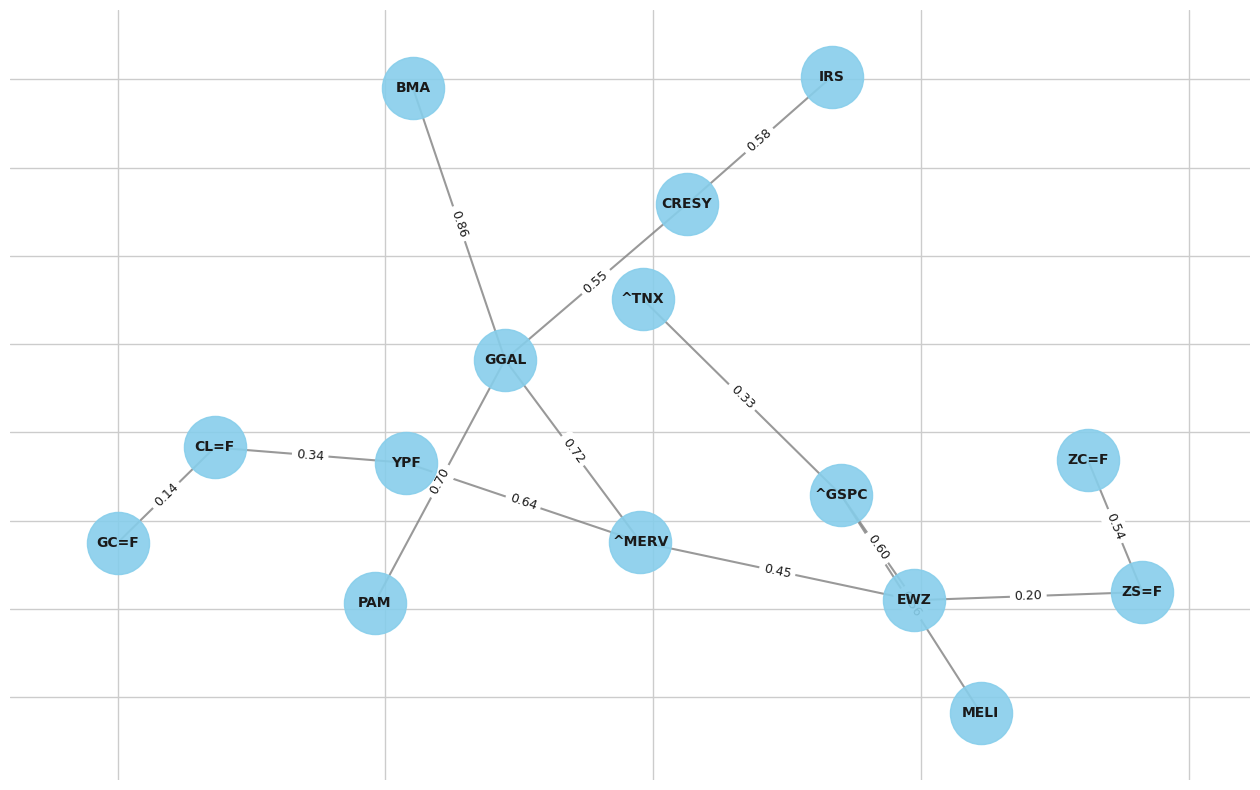


Extrayendo métricas de red MEJORADAS con ventanas de 60 días...
Extracción de métricas completada.

Definiendo la variable objetivo 'crisis'...
Definición de crisis: Retorno del MERVAL a 60 días < -10.0%

Entrenando el modelo RandomForest con las nuevas características...

--- Resultados del Modelo (con métricas mejoradas) ---
               precision    recall  f1-score   support

No Crisis (0)       0.92      0.97      0.94       183
   Crisis (1)       0.54      0.30      0.39        23

     accuracy                           0.89       206
    macro avg       0.73      0.64      0.67       206
 weighted avg       0.87      0.89      0.88       206


Generando gráfico de evolución de las nuevas métricas...


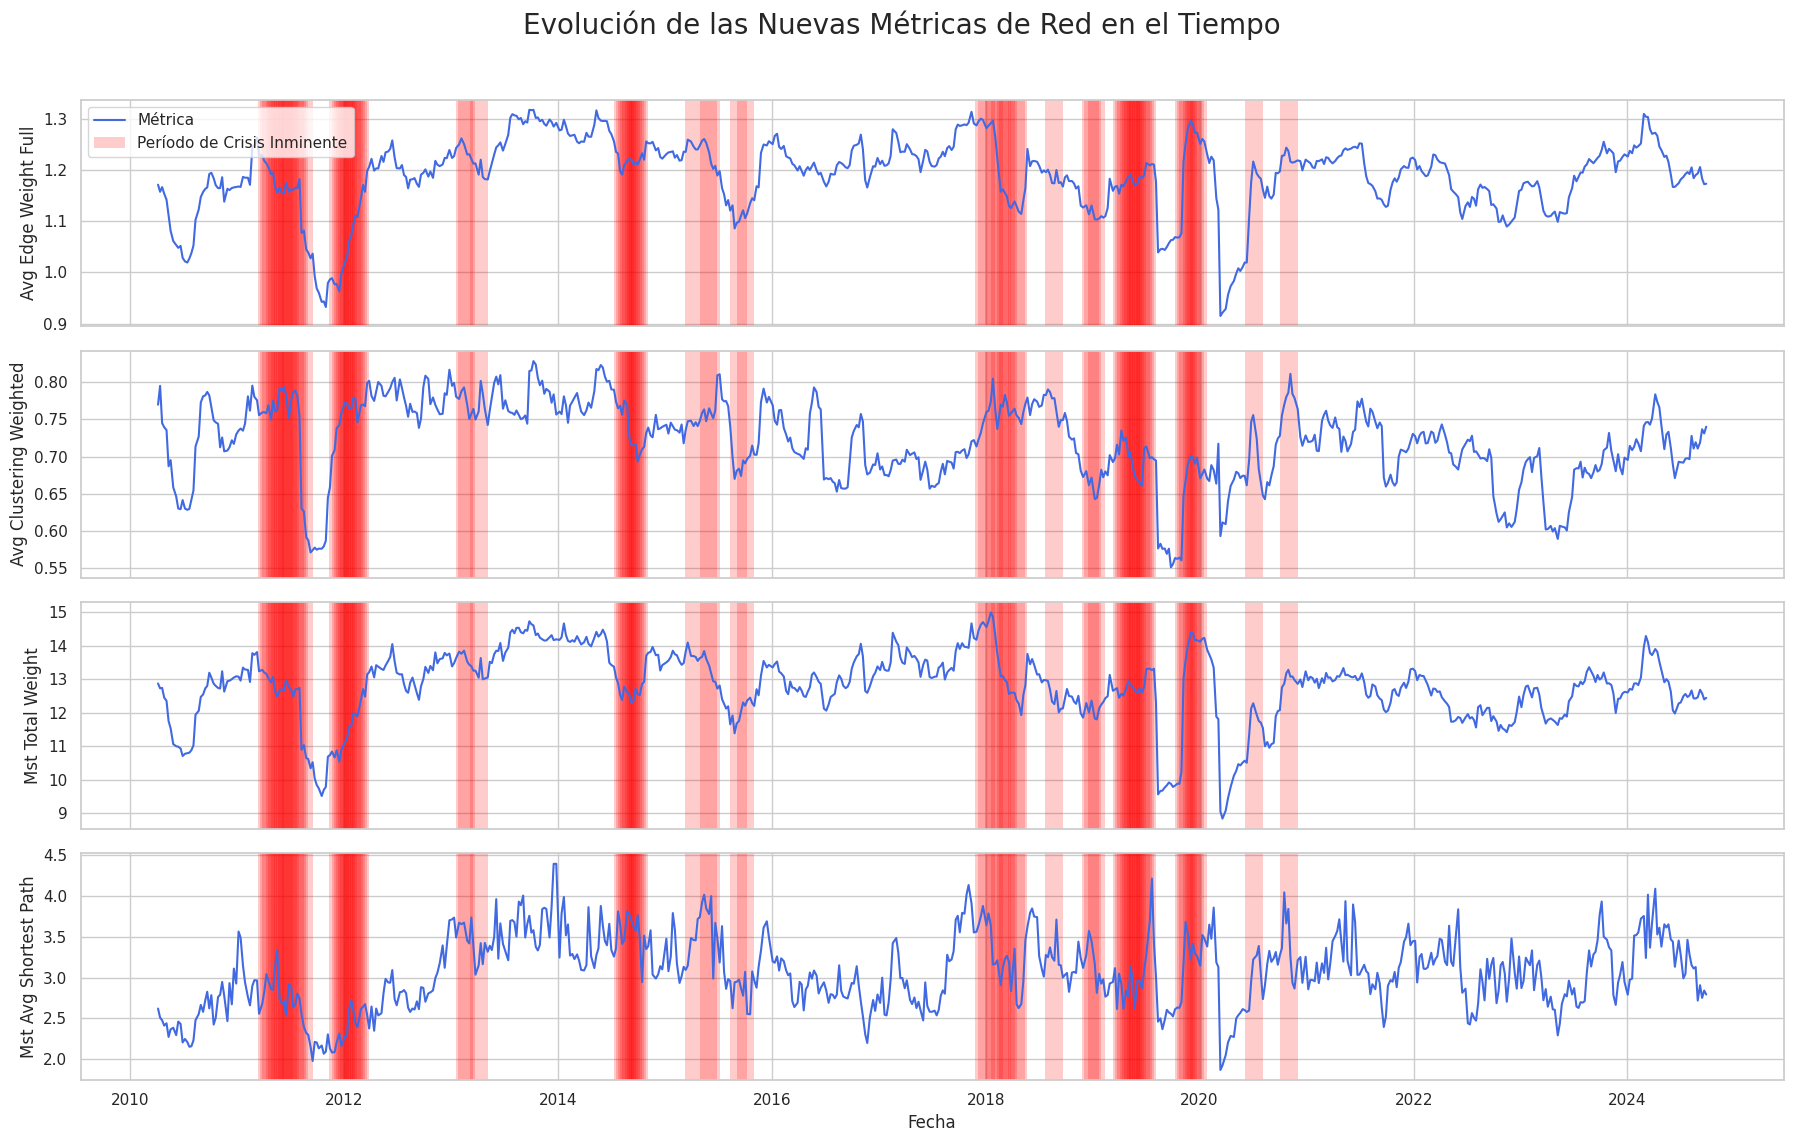


Generando gráfico de importancia de características...


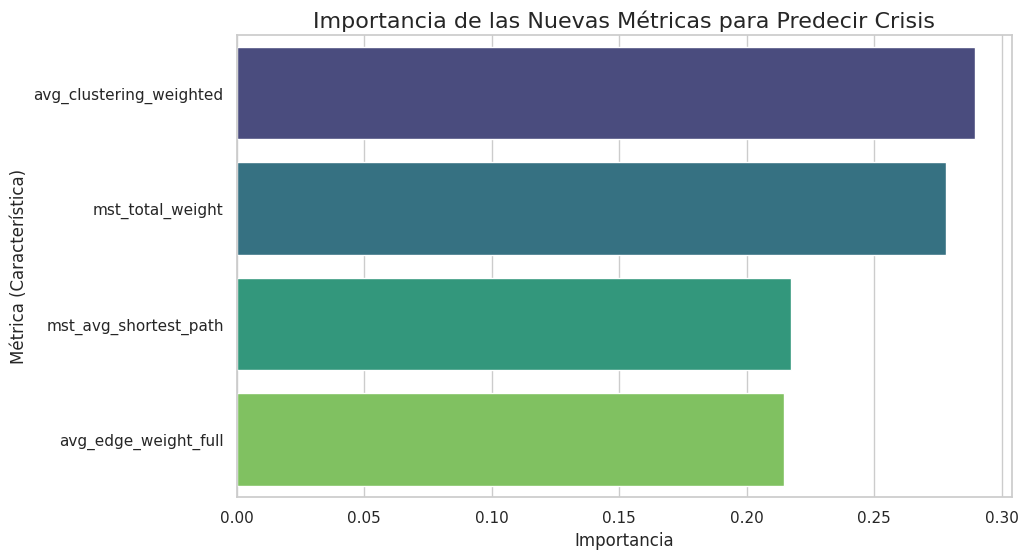

In [8]:
import yfinance as yf
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# --- CONFIGURACIÓN INICIAL ---
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

# --- PASO 1: Definir el Universo de Activos para Argentina ---
tickers = [
    'GGAL', 'YPF', 'PAM', 'LOMA', 'BMA', 'MELI', 'IRS', 'CRESY',
    '^MERV', '^GSPC', 'EWZ',
    'ZS=F', 'ZC=F', 'CL=F', 'GC=F',
    '^TNX'
]

# --- PASO 2: Descargar y Preparar los Datos ---
print("Descargando datos de mercado...")
data = yf.download(tickers, start="2010-01-01", end="2025-01-01", auto_adjust=True)['Close']
data.dropna(axis=1, thresh=len(data) * 0.8, inplace=True)
data.dropna(axis=0, inplace=True)
print("Datos descargados y limpios. Tickers utilizados finalmente:")
print(data.columns.tolist())
log_returns = np.log(data / data.shift(1)).dropna()

# --- GRÁFICO 1: RED MST ESTÁTICA (Sin cambios) ---
def plot_static_mst(log_returns_df):
    print("\nGenerando gráfico de la red MST estática...")
    corr_matrix = log_returns_df.corr()
    dist_matrix = np.sqrt(2 * (1 - corr_matrix))
    G = nx.from_pandas_adjacency(dist_matrix)
    mst = nx.minimum_spanning_tree(G)
    edge_labels = { (u, v): f"{corr_matrix.loc[u, v]:.2f}" for u, v in mst.edges() }
    plt.figure(figsize=(16, 10))
    pos = nx.spring_layout(mst, k=0.75, iterations=50)
    nx.draw_networkx_nodes(mst, pos, node_size=2000, node_color='skyblue', alpha=0.9)
    nx.draw_networkx_edges(mst, pos, width=1.5, alpha=0.8, edge_color='gray')
    nx.draw_networkx_labels(mst, pos, font_size=10, font_weight='bold')
    nx.draw_networkx_edge_labels(mst, pos, edge_labels=edge_labels, font_size=9)
    #plt.title('Red MST Estática del Mercado Argentino y Activos Relacionados', fontsize=20)
    plt.box(False)
    plt.show()

plot_static_mst(log_returns)

# --- PASO 3: Función para Extraer Métricas de Red (VERSIÓN MEJORADA) ---
def extract_network_metrics_enhanced(log_returns, window_size=60, step=5):
    """
    Calcula un conjunto mejorado y dinámico de métricas de red.
    """
    metrics = []
    print(f"\nExtrayendo métricas de red MEJORADAS con ventanas de {window_size} días...")

    for start in range(0, len(log_returns) - window_size, step):
        end = start + window_size
        window_data = log_returns.iloc[start:end]

        corr_matrix = window_data.corr()
        dist_matrix = np.sqrt(2 * (1 - corr_matrix)).fillna(0) # Rellenar NaNs por si acaso

        # 1. Crear el grafo completo y ponderado (G)
        G = nx.from_pandas_adjacency(dist_matrix)

        # 2. Crear el Árbol de Expansión Mínima (MST)
        mst = nx.minimum_spanning_tree(G)

        # 3. Extraer métricas de AMBOS grafos para tener más información
        metrics.append({
            "end_date": log_returns.index[end - 1],

            # --- Métricas del Grafo COMPLETO (ahora serán dinámicas) ---
            "avg_edge_weight_full": G.size(weight='weight') / G.number_of_edges() if G.number_of_edges() > 0 else 0,
            "avg_clustering_weighted": nx.average_clustering(G, weight='weight'),

            # --- Métricas del MST (más específicas sobre el 'esqueleto') ---
            "mst_total_weight": mst.size(weight='weight'),
            "mst_avg_shortest_path": nx.average_shortest_path_length(mst, weight='weight')
        })

    print("Extracción de métricas completada.")
    return pd.DataFrame(metrics).set_index('end_date')

# Ejecutar la nueva función de extracción
network_metrics_df = extract_network_metrics_enhanced(log_returns)

# --- PASO 4: Definir la Variable Objetivo (Crisis) ---
print("\nDefiniendo la variable objetivo 'crisis'...")
if '^MERV' in log_returns.columns:
    future_window = 60
    future_returns = log_returns['^MERV'].rolling(window=future_window).sum().shift(-future_window)
    network_metrics_df['future_return'] = future_returns
    crisis_threshold = -0.10
    network_metrics_df['crisis'] = (network_metrics_df['future_return'] < crisis_threshold).astype(int)
    network_metrics_df.dropna(inplace=True)

    print(f"Definición de crisis: Retorno del MERVAL a {future_window} días < {crisis_threshold*100}%")

    # --- PASO 5: Entrenar el Modelo con las NUEVAS Métricas ---
    print("\nEntrenando el modelo RandomForest con las nuevas características...")

    # 'X' ahora contiene las 4 nuevas y potentes métricas
    feature_columns = ['avg_edge_weight_full', 'avg_clustering_weighted', 'mst_total_weight', 'mst_avg_shortest_path']
    X = network_metrics_df[feature_columns]
    y = network_metrics_df['crisis']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    clf = RandomForestClassifier(random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # --- PASO 6: Mostrar Resultados y Gráficos del Modelo ---
    print("\n--- Resultados del Modelo (con métricas mejoradas) ---")
    print(classification_report(y_test, y_pred, target_names=['No Crisis (0)', 'Crisis (1)']))

    # --- GRÁFICO 2: EVOLUCIÓN DE las NUEVAS MÉTRICAS ---
    print("\nGenerando gráfico de evolución de las nuevas métricas...")
    fig, axes = plt.subplots(nrows=len(feature_columns), ncols=1, figsize=(18, 12), sharex=True)
    fig.suptitle('Evolución de las Nuevas Métricas de Red en el Tiempo', fontsize=20)
    crisis_dates = network_metrics_df[network_metrics_df['crisis'] == 1].index

    for i, metric in enumerate(feature_columns):
        axes[i].plot(network_metrics_df.index, network_metrics_df[metric], label=metric, color='royalblue')
        axes[i].set_ylabel(metric.replace('_', ' ').title())
        for date in crisis_dates:
            axes[i].axvspan(date - pd.Timedelta(days=future_window), date, color='red', alpha=0.2, lw=0)

    axes[0].legend(['Métrica', 'Período de Crisis Inminente'], loc='upper left')
    plt.xlabel('Fecha')
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

    # --- GRÁFICO 3: IMPORTANCIA DE las NUEVAS CARACTERÍSTICAS ---
    print("\nGenerando gráfico de importancia de características...")
    feature_importances = pd.DataFrame({
        'feature': X.columns,
        'importance': clf.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')
    plt.title('Importancia de las Nuevas Métricas para Predecir Crisis', fontsize=16)
    plt.xlabel('Importancia')
    plt.ylabel('Métrica (Característica)')
    plt.show()

else:
    print("\nError: El ticker del MERVAL ('^MERV') no se encuentra en los datos. El modelo no puede ser entrenado.")